## Final Project Submission

Please fill out:
* Student name: David Braslow
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL:


# Overview

# Initialization

In [1]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score
import pickle
import gc

In [2]:
tqdm.pandas()

In [43]:
BERT_MODEL = 'bert-base-cased'
CASED = 'cased' in BERT_MODEL
INPUT = 'raw_files/'
TEXT_COL = 'comment_text'
MAXLEN = 200

## Data Import

In [5]:
train = pd.read_csv(INPUT + 'train.csv').sample(frac = 0.1, random_state = 123)

In [6]:
test = pd.read_csv(INPUT + 'test.csv')

## BERT Embeddings

In [7]:
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

In [8]:
BERT_FP = 'bert-base-cased'

In [9]:
def get_bert_embed_matrix():
    bert = BertModel.from_pretrained(BERT_FP)
    bert_embeddings = list(bert.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

In [10]:
embedding_matrix = get_bert_embed_matrix()

# Data Scrubbing

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180487 entries, 687256 to 1094397
Data columns (total 48 columns):
id                                     180487 non-null int64
target                                 180487 non-null float64
comment_text                           180487 non-null object
severe_toxicity                        180487 non-null float64
obscene                                180487 non-null float64
identity_attack                        180487 non-null float64
insult                                 180487 non-null float64
threat                                 180487 non-null float64
asian                                  40596 non-null float64
atheist                                40596 non-null float64
bisexual                               40596 non-null float64
black                                  40596 non-null float64
buddhist                               40596 non-null float64
christian                              40596 non-null float64
female    

In [11]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
687256,1082203,0.000000,"""And I always say that if I ever believed Cana...",0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,...,317079,rejected,0,0,0,0,0,0.0,4,6
1728190,6241244,0.166667,"have to be fan today; not player. +3 or, +1.5,...",0.0,0.0,0.000000,0.166667,0.0,NaN,NaN,...,394471,approved,0,0,0,1,0,0.0,0,6
1733028,6247184,0.166667,It will help him get impeached for treason.,0.0,0.0,0.000000,0.000000,0.0,NaN,NaN,...,394751,approved,1,0,0,3,3,0.0,0,6
1073761,5428926,0.000000,To me there is a real disconnect when one says...,0.0,0.0,0.000000,0.000000,0.0,NaN,NaN,...,344947,approved,1,0,0,10,0,0.0,0,4
541700,905935,0.000000,We have a spending problem John. I refuse to a...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,164337,approved,0,0,0,1,1,0.0,4,4


In [72]:
train.loc[687256]

id                                                                               1082203
target                                                                                 0
comment_text                           "And I always say that if I ever believed Cana...
severe_toxicity                                                                        0
obscene                                                                                0
identity_attack                                                                 0.166667
insult                                                                                 0
threat                                                                                 0
asian                                                                                  0
atheist                                                                                0
bisexual                                                                               0
black                

In [12]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


## Tokenizing

In [13]:
#Import BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

In [14]:
train['text_tokens'] = train['comment_text'].progress_apply(tokenizer.tokenize)
train['text_tokens'].head()

100%|█████████████████████████████████████████████████████████████████████████| 180487/180487 [03:42<00:00, 810.42it/s]


687256     [", And, I, always, say, that, if, I, ever, be...
1728190    [have, to, be, fan, today, ;, not, player, ., ...
1733028    [It, will, help, him, get, imp, ##each, ##ed, ...
1073761    [To, me, there, is, a, real, disco, ##nne, ##c...
541700     [We, have, a, spending, problem, John, ., I, r...
Name: text_tokens, dtype: object

In [35]:
test['text_tokens'] = test['comment_text'].progress_apply(tokenizer.tokenize)
test['text_tokens'].head()

100%|███████████████████████████████████████████████████████████████████████████| 97320/97320 [02:04<00:00, 784.82it/s]


0    [Jeff, Sessions, is, another, one, of, Trump, ...
1    [I, actually, inspected, the, infrastructure, ...
2    [No, it, won, ', t, ., That, ', s, just, wish,...
3    [Instead, of, w, ##ringing, our, hands, and, n...
4    [how, many, of, you, comment, ##ers, have, gar...
Name: text_tokens, dtype: object

## Encoding

### Checking Vocabulary Coverage

In [ ]:
tokenizer.save_vocabulary('vocab')
bert_vocab_file = open('vocab\\vocab.txt', encoding='utf-8')
bert_vocab_list = bert_vocab_file.read().split(sep = '\n')
bert_vocab_dict = {x: True for x in bert_vocab_list}

In [17]:
# https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [18]:
train_sentences = train["comment_text"].progress_apply(lambda x: x.split()).values
train_vocab = build_vocab(train_sentences)

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:03<00:00, 53748.40it/s]


In [19]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [20]:
check_coverage(train_vocab, bert_vocab_dict)[0:20]

100%|██████████████████████████████████████████████████████████████████████| 379193/379193 [00:00<00:00, 651540.22it/s]


Found embeddings for 5.27% of vocab
Found embeddings for  80.20% of all text


[("don't", 17937),
 ("it's", 10062),
 ('it.', 8463),
 ("I'm", 8107),
 ("It's", 8013),
 ("doesn't", 6098),
 ("can't", 6081),
 ("didn't", 5233),
 ("isn't", 3945),
 ("that's", 3855),
 ("That's", 3769),
 ("you're", 3679),
 ('them.', 3524),
 ('Mr.', 3133),
 ('it,', 2956),
 ("won't", 2922),
 ('Trudeau', 2785),
 ('--', 2741),
 ('that.', 2721),
 ("I've", 2695)]

In [21]:
def clean_text(x):
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~&' + '“”’':
        x = x.replace(punct, '')
    return x.split()

In [22]:
train_sentences_check1 = train["comment_text"].progress_apply(clean_text).values
train_vocab_check1 = build_vocab(train_sentences_check1)

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:02<00:00, 66209.53it/s]


In [23]:
check_coverage(train_vocab_check1, bert_vocab_dict)[0:20]

100%|██████████████████████████████████████████████████████████████████████| 155148/155148 [00:00<00:00, 745906.61it/s]


Found embeddings for 13.14% of vocab
Found embeddings for  92.79% of all text


[('Trudeau', 3738),
 ('NOT', 2002),
 ('trump', 1421),
 ('GOP', 1326),
 ('liberals', 1174),
 ('Alaskans', 1166),
 ('taxpayers', 1153),
 ('Anchorage', 1148),
 ('dont', 1090),
 ('PFD', 891),
 ('ALL', 863),
 ('LOL', 825),
 ('Obamacare', 800),
 ('ie', 788),
 ('conservatives', 771),
 ('taxpayer', 758),
 ('Comey', 754),
 ('billions', 738),
 ('ACA', 738),
 ('Trumps', 685)]

### Encoding Comments

In [24]:
train['text_ids'] = train['text_tokens'].progress_apply(tokenizer.convert_tokens_to_ids)
train['text_ids'].head(10)

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:04<00:00, 38923.22it/s]


687256     [107, 1262, 146, 1579, 1474, 1115, 1191, 146, ...
1728190    [1138, 1106, 1129, 5442, 2052, 132, 1136, 1591...
1733028    [1135, 1209, 1494, 1140, 1243, 24034, 17269, 1...
1073761    [1706, 1143, 1175, 1110, 170, 1842, 19959, 109...
541700     [1284, 1138, 170, 5369, 2463, 1287, 119, 146, ...
900691     [146, 112, 182, 1136, 170, 5442, 1104, 8499, 1...
393193     [23320, 112, 189, 1129, 170, 1618, 1591, 1773,...
1121977    [1247, 1132, 170, 1974, 1104, 5144, 6420, 1433...
1411658    [4514, 1128, 1111, 1142, 1159, 1193, 15656, 11...
300499     [1109, 2501, 1110, 1115, 1128, 2834, 6187, 102...
Name: text_ids, dtype: object

In [37]:
test['text_ids'] = test['text_tokens'].progress_apply(tokenizer.convert_tokens_to_ids)
test['text_ids'].head(10)

100%|█████████████████████████████████████████████████████████████████████████| 97320/97320 [00:02<00:00, 42702.96it/s]


0    [4274, 18003, 1110, 1330, 1141, 1104, 8499, 11...
1    [146, 2140, 22457, 1103, 6557, 1113, 2224, 253...
2    [1302, 1122, 1281, 112, 189, 119, 1337, 112, 1...
3    [3743, 1104, 192, 27812, 1412, 1493, 1105, 114...
4    [1293, 1242, 1104, 1128, 7368, 1468, 1138, 149...
5    [2009, 1169, 112, 189, 1103, 10421, 111, 11508...
6    [1337, 112, 188, 1640, 1151, 5664, 117, 4804, ...
7    [5403, 1103, 4692, 1111, 2699, 117, 6312, 117,...
8    [1573, 1152, 1328, 1106, 1508, 1244, 1113, 110...
9    [1302, 117, 1185, 1115, 1169, 112, 189, 1129, ...
Name: text_ids, dtype: object

### Clipping

In [45]:
def id_clip(ids, num_ids = MAXLEN):
    ids_clipped = list(np.zeros(num_ids, dtype=np.int))
    i = 0
    while (i < num_ids) & (i < len(ids)):
        ids_clipped[i] = ids[i]
        i += 1
    return np.array(ids_clipped)

In [46]:
train['text_ids_clipped'] = train['text_ids'].progress_apply(id_clip)

100%|███████████████████████████████████████████████████████████████████████| 180487/180487 [00:10<00:00, 17541.74it/s]


In [47]:
test['text_ids_clipped'] = test['text_ids'].progress_apply(id_clip)

100%|█████████████████████████████████████████████████████████████████████████| 97320/97320 [00:05<00:00, 17592.19it/s]


# Exploring the Data

In [73]:
import matplotlib.pyplot as plt

## Toxicity (Target)

count    180487.000000
mean          0.103197
std           0.197017
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: target, dtype: float64

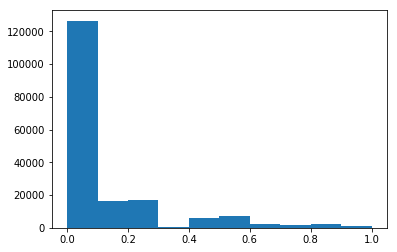

In [81]:
plt.hist(train['target'])
train['target'].describe()

In [86]:
np.mean(np.round(train['target'].values))

0.058874046330206604

### Toxicity by Subgroup

In [82]:
identity_columns = ['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']
train[identity_columns].mean()

male                             0.107505
female                           0.128989
homosexual_gay_or_lesbian        0.025013
christian                        0.094331
jewish                           0.018731
muslim                           0.050115
black                            0.035395
white                            0.057116
psychiatric_or_mental_illness    0.011779
dtype: float64

In [80]:
for identity in identity_columns:
    identity_df = train[train[identity] == 1]
    identity_tox = np.round(identity_df['target'].values)
    n_toxic = sum(identity_tox)
    n_tot = len(identity_tox)
    pct_toxic = n_toxic/n_tot * 100
    print(f"{identity}: {pct_toxic}%")

male: 10.020768431983386%
female: 9.69520103761349%
homosexual_gay_or_lesbian: 25.099601593625497%
christian: 6.9674471730439755%
jewish: 9.433962264150944%
muslim: 14.241001564945227%
black: 25.311720698254366%
white: 20.679012345679013%
psychiatric_or_mental_illness: 7.5%


In [89]:
identity_columns_long = ['asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white']
for identity in identity_columns_long:
    identity_df = train[train[identity] == 1]
    identity_tox = np.round(identity_df['target'].values)
    n_toxic = sum(identity_tox)
    n_tot = len(identity_tox)
    if n_tot == 0:
        continue
    pct_toxic = n_toxic/n_tot * 100
    print(f"{identity}: {pct_toxic}%")

asian: 14.529914529914532%
atheist: 12.727272727272727%
bisexual: 16.666666666666664%
black: 25.311720698254366%
buddhist: 0.0%
christian: 6.9674471730439755%
female: 9.69520103761349%
heterosexual: 10.0%
hindu: 0.0%
homosexual_gay_or_lesbian: 25.099601593625497%
jewish: 9.433962264150944%
latino: 12.0%
male: 10.020768431983386%
muslim: 14.241001564945227%
other_race_or_ethnicity: 0.0%
other_religion: 0.0%
psychiatric_or_mental_illness: 7.5%
transgender: 17.391304347826086%
white: 20.679012345679013%


## Toxic Words

### Identify Important Words with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

count_vectorizer = CountVectorizer(max_features=20000)
count_vectorizer.fit(train['comment_text'].values)
top_20000_words = count_vectorizer.get_feature_names()
top_20000_words

In [ ]:
# https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

In [121]:
def tokenize(text):
    tokenized_text = word_tokenize(text)
    return tokenized_text

def count_vectorize(song, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(song))
    
    song_dict = {i:0 for i in unique_words}
    
    for word in song:
        song_dict[word] += 1
    
    return song_dict

def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

def tf_idf(list_of_dicts):
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        doc_tf = term_frequency(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

In [ ]:
def main(comments):
    # Iterate through list of filenames and read each in
    count_vectorized_all_documents = []
    for comment in comments:
        raw_data = comment
        # Clean and tokenize raw text
        tokenized = tokenize(raw_data)
        
        # Get count vectorized representation and store in count_vectorized_all_documents  
        count_vectorized_document = count_vectorize(tokenized)
        count_vectorized_all_documents.append(count_vectorized_document)
    
    # Now that we have a list of BoW respresentations of each song, create a tf-idf representation of everything
    tf_idf_all_docs = tf_idf(count_vectorized_all_documents)
    
    return tf_idf_all_docs

tf_idf_all_docs = main(train['comment_text'].values)
print(list(tf_idf_all_docs[0])[:10])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Modeling the Data

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras import backend as K
import keras.layers as L
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model
from keras.optimizers import Adam

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf

Using TensorFlow backend.


In [29]:
y_identities = (train[identity_columns] >= 0.5).astype(int).values

# Overall
weights = np.ones((len(train),)) / 4
# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train['target'].values>=0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train['target'].values<0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
loss_weight = 1.0 / weights.mean()

y_train = np.vstack([(train['target'].values>=0.5).astype(np.int),weights]).T
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']].values

In [53]:
loss_weight

3.2067764689160136

In [48]:
x_train = np.vstack(train['text_ids_clipped'].to_numpy())
x_test = np.vstack(test['text_ids_clipped'].to_numpy())

In [49]:
with open('temporary.pickle', mode='wb') as f:
    pickle.dump(x_test, f) # use temporary file to reduce memory

del x_test

In [44]:
def build_model(embedding_matrix, num_aux_targets, loss_weight):
    '''
    credits go to: https://www.kaggle.com/thousandvoices/simple-lstm/
    '''
    words = Input(shape=(MAXLEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([GlobalMaxPooling1D()(x),GlobalAveragePooling1D()(x),])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss=[custom_loss,'binary_crossentropy'], loss_weights=[loss_weight, 1.0], optimizer='adam')

    return model

In [31]:
def custom_loss(y_true, y_pred):
    return binary_crossentropy(K.reshape(y_true[:,0],(-1,1)), y_pred) * y_true[:,1]

In [58]:
build_model(embedding_matrix, y_aux_train.shape[-1],loss_weight).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 768)     22268928    input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 200, 768)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 200, 256)     919552      spatial_dropout1d_5[0][0]        
__________________________________________________________________________________________________
bidirectio

In [32]:
tr_ind, val_ind = train_test_split(list(range(len(x_train))) ,test_size = 0.05, random_state = 123)

In [33]:
tf.reset_default_graph()
gc.collect()

7

In [52]:
NUM_MODELS = 1

BATCH_SIZE = 256
EPOCHS = 12
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 512
checkpoint_predictions = []
checkpoint_val_preds = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1],loss_weight)
    for global_epoch in range(EPOCHS):
        history = model.fit(x_train[tr_ind],[y_train[tr_ind], y_aux_train[tr_ind]],validation_data = (x_train[val_ind],[y_train[val_ind], y_aux_train[val_ind]]),
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=1,
            callbacks=[
                LearningRateScheduler(lambda epoch: 1e-3 * (0.6 ** global_epoch))
            ]
        )
        with open('temporary.pickle', mode='rb') as f:
            x_test = pickle.load(f) # use temporary file to reduce memory
        checkpoint_predictions.append(model.predict(x_test, batch_size=BATCH_SIZE)[0].flatten())
        checkpoint_val_preds.append(model.predict(x_train[val_ind], batch_size=BATCH_SIZE)[0].flatten())
        del x_test
        gc.collect()
        weights.append(2 ** global_epoch)
    del model
    gc.collect()

predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 28160/171462 [===>..........................] - ETA: 36:12 - loss: 1.3399 - dense_12_loss: 0.2087 - dense_13_loss: 0.67 - ETA: 19:29 - loss: 1.1830 - dense_12_loss: 0.1775 - dense_13_loss: 0.61 - ETA: 13:56 - loss: 1.1126 - dense_12_loss: 0.1819 - dense_13_loss: 0.52 - ETA: 11:09 - loss: 0.9806 - dense_12_loss: 0.1644 - dense_13_loss: 0.45 - ETA: 9:29 - loss: 0.8764 - dense_12_loss: 0.1509 - dense_13_loss: 0.3925 - ETA: 8:22 - loss: 0.8575 - dense_12_loss: 0.1545 - dense_13_loss: 0.362 - ETA: 7:35 - loss: 0.8310 - dense_12_loss: 0.1547 - dense_13_loss: 0.334 - ETA: 6:59 - loss: 0.8127 - dense_12_loss: 0.1555 - dense_13_loss: 0.313 - ETA: 6:30 - loss: 0.7844 - dense_12_loss: 0.1521 - dense_13_loss: 0.296 - ETA: 6:08 - loss: 0.7486 - dense_12_loss: 0.1459 - dense_13_loss: 0.280 - ETA: 5:49 - loss: 0.7244 - dense_12_loss: 0.1425 - dense_13_loss: 0.267 - ETA: 5:34 - loss: 0.7166 - dense_12_loss: 0.1429 - dense_13_loss: 0.258 - ETA: 5:21 - loss: 0.7079 - dense_12_loss: 0.1427 - dense_13_lo

 56576/171462 [========>.....................] - ETA: 2:41 - loss: 0.5706 - dense_12_loss: 0.1280 - dense_13_loss: 0.160 - ETA: 2:40 - loss: 0.5697 - dense_12_loss: 0.1278 - dense_13_loss: 0.159 - ETA: 2:40 - loss: 0.5693 - dense_12_loss: 0.1278 - dense_13_loss: 0.159 - ETA: 2:40 - loss: 0.5691 - dense_12_loss: 0.1277 - dense_13_loss: 0.159 - ETA: 2:39 - loss: 0.5682 - dense_12_loss: 0.1275 - dense_13_loss: 0.159 - ETA: 2:39 - loss: 0.5680 - dense_12_loss: 0.1275 - dense_13_loss: 0.159 - ETA: 2:38 - loss: 0.5687 - dense_12_loss: 0.1277 - dense_13_loss: 0.159 - ETA: 2:38 - loss: 0.5679 - dense_12_loss: 0.1276 - dense_13_loss: 0.158 - ETA: 2:38 - loss: 0.5675 - dense_12_loss: 0.1274 - dense_13_loss: 0.158 - ETA: 2:37 - loss: 0.5678 - dense_12_loss: 0.1275 - dense_13_loss: 0.158 - ETA: 2:37 - loss: 0.5670 - dense_12_loss: 0.1274 - dense_13_loss: 0.158 - ETA: 2:36 - loss: 0.5665 - dense_12_loss: 0.1273 - dense_13_loss: 0.158 - ETA: 2:36 - loss: 0.5658 - dense_12_loss: 0.1271 - dense_13_los

 84992/171462 [=============>................] - ETA: 2:03 - loss: 0.5399 - dense_12_loss: 0.1215 - dense_13_loss: 0.150 - ETA: 2:03 - loss: 0.5398 - dense_12_loss: 0.1215 - dense_13_loss: 0.150 - ETA: 2:03 - loss: 0.5392 - dense_12_loss: 0.1214 - dense_13_loss: 0.150 - ETA: 2:02 - loss: 0.5393 - dense_12_loss: 0.1214 - dense_13_loss: 0.150 - ETA: 2:02 - loss: 0.5388 - dense_12_loss: 0.1212 - dense_13_loss: 0.150 - ETA: 2:02 - loss: 0.5382 - dense_12_loss: 0.1211 - dense_13_loss: 0.149 - ETA: 2:01 - loss: 0.5377 - dense_12_loss: 0.1209 - dense_13_loss: 0.149 - ETA: 2:01 - loss: 0.5378 - dense_12_loss: 0.1210 - dense_13_loss: 0.149 - ETA: 2:01 - loss: 0.5376 - dense_12_loss: 0.1209 - dense_13_loss: 0.149 - ETA: 2:01 - loss: 0.5374 - dense_12_loss: 0.1209 - dense_13_loss: 0.149 - ETA: 2:00 - loss: 0.5369 - dense_12_loss: 0.1208 - dense_13_loss: 0.149 - ETA: 2:00 - loss: 0.5365 - dense_12_loss: 0.1207 - dense_13_loss: 0.149 - ETA: 2:00 - loss: 0.5365 - dense_12_loss: 0.1206 - dense_13_los

113408/171462 [==================>...........] - ETA: 1:32 - loss: 0.5065 - dense_12_loss: 0.1132 - dense_13_loss: 0.143 - ETA: 1:32 - loss: 0.5062 - dense_12_loss: 0.1131 - dense_13_loss: 0.143 - ETA: 1:31 - loss: 0.5057 - dense_12_loss: 0.1130 - dense_13_loss: 0.143 - ETA: 1:31 - loss: 0.5057 - dense_12_loss: 0.1130 - dense_13_loss: 0.143 - ETA: 1:31 - loss: 0.5052 - dense_12_loss: 0.1128 - dense_13_loss: 0.143 - ETA: 1:30 - loss: 0.5050 - dense_12_loss: 0.1128 - dense_13_loss: 0.143 - ETA: 1:30 - loss: 0.5045 - dense_12_loss: 0.1127 - dense_13_loss: 0.143 - ETA: 1:30 - loss: 0.5046 - dense_12_loss: 0.1127 - dense_13_loss: 0.143 - ETA: 1:30 - loss: 0.5041 - dense_12_loss: 0.1125 - dense_13_loss: 0.143 - ETA: 1:29 - loss: 0.5041 - dense_12_loss: 0.1125 - dense_13_loss: 0.143 - ETA: 1:29 - loss: 0.5038 - dense_12_loss: 0.1124 - dense_13_loss: 0.143 - ETA: 1:29 - loss: 0.5037 - dense_12_loss: 0.1124 - dense_13_loss: 0.143 - ETA: 1:29 - loss: 0.5034 - dense_12_loss: 0.1123 - dense_13_los

142336/171462 [=======================>......] - ETA: 1:02 - loss: 0.4811 - dense_12_loss: 0.1066 - dense_13_loss: 0.139 - ETA: 1:02 - loss: 0.4812 - dense_12_loss: 0.1066 - dense_13_loss: 0.139 - ETA: 1:01 - loss: 0.4810 - dense_12_loss: 0.1065 - dense_13_loss: 0.139 - ETA: 1:01 - loss: 0.4809 - dense_12_loss: 0.1065 - dense_13_loss: 0.139 - ETA: 1:01 - loss: 0.4806 - dense_12_loss: 0.1064 - dense_13_loss: 0.139 - ETA: 1:01 - loss: 0.4804 - dense_12_loss: 0.1064 - dense_13_loss: 0.139 - ETA: 1:00 - loss: 0.4803 - dense_12_loss: 0.1063 - dense_13_loss: 0.139 - ETA: 1:00 - loss: 0.4800 - dense_12_loss: 0.1063 - dense_13_loss: 0.139 - ETA: 1:00 - loss: 0.4798 - dense_12_loss: 0.1062 - dense_13_loss: 0.139 - ETA: 1:00 - loss: 0.4796 - dense_12_loss: 0.1061 - dense_13_loss: 0.139 - ETA: 59s - loss: 0.4794 - dense_12_loss: 0.1061 - dense_13_loss: 0.139 - ETA: 59s - loss: 0.4791 - dense_12_loss: 0.1060 - dense_13_loss: 0.13 - ETA: 59s - loss: 0.4789 - dense_12_loss: 0.1060 - dense_13_loss: 0

171462/171462 [==============================] - ETA: 31s - loss: 0.4609 - dense_12_loss: 0.1014 - dense_13_loss: 0.13 - ETA: 30s - loss: 0.4609 - dense_12_loss: 0.1014 - dense_13_loss: 0.13 - ETA: 30s - loss: 0.4607 - dense_12_loss: 0.1013 - dense_13_loss: 0.13 - ETA: 30s - loss: 0.4607 - dense_12_loss: 0.1013 - dense_13_loss: 0.13 - ETA: 30s - loss: 0.4606 - dense_12_loss: 0.1013 - dense_13_loss: 0.13 - ETA: 29s - loss: 0.4603 - dense_12_loss: 0.1012 - dense_13_loss: 0.13 - ETA: 29s - loss: 0.4602 - dense_12_loss: 0.1012 - dense_13_loss: 0.13 - ETA: 29s - loss: 0.4602 - dense_12_loss: 0.1012 - dense_13_loss: 0.13 - ETA: 29s - loss: 0.4600 - dense_12_loss: 0.1011 - dense_13_loss: 0.13 - ETA: 28s - loss: 0.4598 - dense_12_loss: 0.1011 - dense_13_loss: 0.13 - ETA: 28s - loss: 0.4596 - dense_12_loss: 0.1010 - dense_13_loss: 0.13 - ETA: 28s - loss: 0.4597 - dense_12_loss: 0.1010 - dense_13_loss: 0.13 - ETA: 27s - loss: 0.4596 - dense_12_loss: 0.1010 - dense_13_loss: 0.13 - ETA: 27s - loss

Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 28160/171462 [===>..........................] - ETA: 3:07 - loss: 0.4006 - dense_12_loss: 0.0818 - dense_13_loss: 0.138 - ETA: 3:02 - loss: 0.4011 - dense_12_loss: 0.0835 - dense_13_loss: 0.133 - ETA: 2:59 - loss: 0.3762 - dense_12_loss: 0.0778 - dense_13_loss: 0.126 - ETA: 2:59 - loss: 0.3732 - dense_12_loss: 0.0775 - dense_13_loss: 0.124 - ETA: 2:59 - loss: 0.3786 - dense_12_loss: 0.0789 - dense_13_loss: 0.125 - ETA: 2:58 - loss: 0.3725 - dense_12_loss: 0.0775 - dense_13_loss: 0.124 - ETA: 2:58 - loss: 0.3732 - dense_12_loss: 0.0782 - dense_13_loss: 0.122 - ETA: 2:57 - loss: 0.3663 - dense_12_loss: 0.0758 - dense_13_loss: 0.123 - ETA: 2:58 - loss: 0.3691 - dense_12_loss: 0.0765 - dense_13_loss: 0.123 - ETA: 2:57 - loss: 0.3626 - dense_12_loss: 0.0750 - dense_13_loss: 0.122 - ETA: 2:57 - loss: 0.3574 - dense_12_loss: 0.0735 - dense_13_loss: 0.121 - ETA: 2:58 - loss: 0.3595 - dense_12_loss: 0.0741 - dense_13_loss: 0.121 - ETA: 2:58 - loss: 0.3601 - dense_12_loss: 0.0740 - dense_13_los

 56576/171462 [========>.....................] - ETA: 2:37 - loss: 0.3670 - dense_12_loss: 0.0769 - dense_13_loss: 0.120 - ETA: 2:37 - loss: 0.3672 - dense_12_loss: 0.0770 - dense_13_loss: 0.120 - ETA: 2:37 - loss: 0.3671 - dense_12_loss: 0.0769 - dense_13_loss: 0.120 - ETA: 2:36 - loss: 0.3676 - dense_12_loss: 0.0771 - dense_13_loss: 0.120 - ETA: 2:36 - loss: 0.3671 - dense_12_loss: 0.0769 - dense_13_loss: 0.120 - ETA: 2:36 - loss: 0.3676 - dense_12_loss: 0.0771 - dense_13_loss: 0.120 - ETA: 2:35 - loss: 0.3674 - dense_12_loss: 0.0770 - dense_13_loss: 0.120 - ETA: 2:35 - loss: 0.3666 - dense_12_loss: 0.0768 - dense_13_loss: 0.120 - ETA: 2:35 - loss: 0.3679 - dense_12_loss: 0.0772 - dense_13_loss: 0.120 - ETA: 2:35 - loss: 0.3681 - dense_12_loss: 0.0772 - dense_13_loss: 0.120 - ETA: 2:34 - loss: 0.3677 - dense_12_loss: 0.0771 - dense_13_loss: 0.120 - ETA: 2:34 - loss: 0.3679 - dense_12_loss: 0.0772 - dense_13_loss: 0.120 - ETA: 2:34 - loss: 0.3676 - dense_12_loss: 0.0771 - dense_13_los

 84992/171462 [=============>................] - ETA: 2:05 - loss: 0.3718 - dense_12_loss: 0.0780 - dense_13_loss: 0.121 - ETA: 2:05 - loss: 0.3717 - dense_12_loss: 0.0780 - dense_13_loss: 0.121 - ETA: 2:05 - loss: 0.3721 - dense_12_loss: 0.0781 - dense_13_loss: 0.121 - ETA: 2:04 - loss: 0.3719 - dense_12_loss: 0.0781 - dense_13_loss: 0.121 - ETA: 2:04 - loss: 0.3715 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 2:04 - loss: 0.3713 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 2:04 - loss: 0.3713 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 2:03 - loss: 0.3713 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 2:03 - loss: 0.3712 - dense_12_loss: 0.0778 - dense_13_loss: 0.121 - ETA: 2:03 - loss: 0.3713 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 2:03 - loss: 0.3710 - dense_12_loss: 0.0778 - dense_13_loss: 0.121 - ETA: 2:02 - loss: 0.3708 - dense_12_loss: 0.0777 - dense_13_loss: 0.121 - ETA: 2:02 - loss: 0.3709 - dense_12_loss: 0.0778 - dense_13_los

113408/171462 [==================>...........] - ETA: 1:34 - loss: 0.3707 - dense_12_loss: 0.0778 - dense_13_loss: 0.121 - ETA: 1:34 - loss: 0.3704 - dense_12_loss: 0.0777 - dense_13_loss: 0.121 - ETA: 1:33 - loss: 0.3705 - dense_12_loss: 0.0778 - dense_13_loss: 0.121 - ETA: 1:33 - loss: 0.3707 - dense_12_loss: 0.0778 - dense_13_loss: 0.121 - ETA: 1:33 - loss: 0.3708 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:33 - loss: 0.3707 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:32 - loss: 0.3709 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:32 - loss: 0.3709 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:32 - loss: 0.3710 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:31 - loss: 0.3710 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:31 - loss: 0.3708 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:31 - loss: 0.3710 - dense_12_loss: 0.0779 - dense_13_loss: 0.121 - ETA: 1:31 - loss: 0.3710 - dense_12_loss: 0.0779 - dense_13_los

142336/171462 [=======================>......] - ETA: 1:03 - loss: 0.3702 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:03 - loss: 0.3701 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:02 - loss: 0.3702 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:02 - loss: 0.3700 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:02 - loss: 0.3701 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:01 - loss: 0.3701 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:01 - loss: 0.3701 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:01 - loss: 0.3702 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:01 - loss: 0.3701 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:00 - loss: 0.3701 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:00 - loss: 0.3701 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 1:00 - loss: 0.3702 - dense_12_loss: 0.0778 - dense_13_loss: 0.120 - ETA: 59s - loss: 0.3703 - dense_12_loss: 0.0778 - dense_13_loss

171462/171462 [==============================] - ETA: 31s - loss: 0.3683 - dense_12_loss: 0.0773 - dense_13_loss: 0.12 - ETA: 31s - loss: 0.3683 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 31s - loss: 0.3680 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 30s - loss: 0.3681 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 30s - loss: 0.3680 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 30s - loss: 0.3680 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 29s - loss: 0.3679 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 29s - loss: 0.3678 - dense_12_loss: 0.0771 - dense_13_loss: 0.12 - ETA: 29s - loss: 0.3680 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 29s - loss: 0.3680 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 28s - loss: 0.3679 - dense_12_loss: 0.0772 - dense_13_loss: 0.12 - ETA: 28s - loss: 0.3678 - dense_12_loss: 0.0771 - dense_13_loss: 0.12 - ETA: 28s - loss: 0.3678 - dense_12_loss: 0.0771 - dense_13_loss: 0.12 - ETA: 27s - loss

Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 28160/171462 [===>..........................] - ETA: 3:07 - loss: 0.2461 - dense_12_loss: 0.0476 - dense_13_loss: 0.093 - ETA: 3:02 - loss: 0.2690 - dense_12_loss: 0.0517 - dense_13_loss: 0.103 - ETA: 2:59 - loss: 0.2592 - dense_12_loss: 0.0503 - dense_13_loss: 0.097 - ETA: 2:58 - loss: 0.3036 - dense_12_loss: 0.0625 - dense_13_loss: 0.103 - ETA: 2:56 - loss: 0.3076 - dense_12_loss: 0.0626 - dense_13_loss: 0.106 - ETA: 2:56 - loss: 0.3041 - dense_12_loss: 0.0614 - dense_13_loss: 0.107 - ETA: 2:56 - loss: 0.3054 - dense_12_loss: 0.0617 - dense_13_loss: 0.107 - ETA: 2:55 - loss: 0.2998 - dense_12_loss: 0.0604 - dense_13_loss: 0.106 - ETA: 2:56 - loss: 0.2979 - dense_12_loss: 0.0596 - dense_13_loss: 0.106 - ETA: 2:56 - loss: 0.3110 - dense_12_loss: 0.0631 - dense_13_loss: 0.108 - ETA: 2:56 - loss: 0.3180 - dense_12_loss: 0.0650 - dense_13_loss: 0.109 - ETA: 2:56 - loss: 0.3221 - dense_12_loss: 0.0658 - dense_13_loss: 0.111 - ETA: 2:56 - loss: 0.3249 - dense_12_loss: 0.0666 - dense_13_los

 56576/171462 [========>.....................] - ETA: 2:36 - loss: 0.3488 - dense_12_loss: 0.0723 - dense_13_loss: 0.116 - ETA: 2:36 - loss: 0.3497 - dense_12_loss: 0.0726 - dense_13_loss: 0.117 - ETA: 2:35 - loss: 0.3497 - dense_12_loss: 0.0725 - dense_13_loss: 0.117 - ETA: 2:35 - loss: 0.3494 - dense_12_loss: 0.0725 - dense_13_loss: 0.117 - ETA: 2:35 - loss: 0.3490 - dense_12_loss: 0.0723 - dense_13_loss: 0.117 - ETA: 2:34 - loss: 0.3495 - dense_12_loss: 0.0725 - dense_13_loss: 0.117 - ETA: 2:34 - loss: 0.3507 - dense_12_loss: 0.0728 - dense_13_loss: 0.117 - ETA: 2:34 - loss: 0.3506 - dense_12_loss: 0.0728 - dense_13_loss: 0.117 - ETA: 2:34 - loss: 0.3506 - dense_12_loss: 0.0728 - dense_13_loss: 0.117 - ETA: 2:33 - loss: 0.3500 - dense_12_loss: 0.0726 - dense_13_loss: 0.117 - ETA: 2:33 - loss: 0.3509 - dense_12_loss: 0.0729 - dense_13_loss: 0.117 - ETA: 2:33 - loss: 0.3514 - dense_12_loss: 0.0730 - dense_13_loss: 0.117 - ETA: 2:32 - loss: 0.3514 - dense_12_loss: 0.0730 - dense_13_los

 84992/171462 [=============>................] - ETA: 2:05 - loss: 0.3567 - dense_12_loss: 0.0744 - dense_13_loss: 0.118 - ETA: 2:04 - loss: 0.3574 - dense_12_loss: 0.0746 - dense_13_loss: 0.118 - ETA: 2:04 - loss: 0.3572 - dense_12_loss: 0.0745 - dense_13_loss: 0.118 - ETA: 2:04 - loss: 0.3570 - dense_12_loss: 0.0745 - dense_13_loss: 0.118 - ETA: 2:04 - loss: 0.3572 - dense_12_loss: 0.0745 - dense_13_loss: 0.118 - ETA: 2:03 - loss: 0.3570 - dense_12_loss: 0.0744 - dense_13_loss: 0.118 - ETA: 2:03 - loss: 0.3567 - dense_12_loss: 0.0744 - dense_13_loss: 0.118 - ETA: 2:03 - loss: 0.3565 - dense_12_loss: 0.0743 - dense_13_loss: 0.118 - ETA: 2:03 - loss: 0.3565 - dense_12_loss: 0.0743 - dense_13_loss: 0.118 - ETA: 2:02 - loss: 0.3569 - dense_12_loss: 0.0744 - dense_13_loss: 0.118 - ETA: 2:02 - loss: 0.3571 - dense_12_loss: 0.0745 - dense_13_loss: 0.118 - ETA: 2:02 - loss: 0.3571 - dense_12_loss: 0.0745 - dense_13_loss: 0.118 - ETA: 2:01 - loss: 0.3571 - dense_12_loss: 0.0745 - dense_13_los

113408/171462 [==================>...........] - ETA: 1:34 - loss: 0.3536 - dense_12_loss: 0.0735 - dense_13_loss: 0.117 - ETA: 1:34 - loss: 0.3535 - dense_12_loss: 0.0735 - dense_13_loss: 0.117 - ETA: 1:33 - loss: 0.3538 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:33 - loss: 0.3538 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:33 - loss: 0.3537 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:32 - loss: 0.3538 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:32 - loss: 0.3537 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:32 - loss: 0.3539 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:32 - loss: 0.3540 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:31 - loss: 0.3540 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:31 - loss: 0.3538 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:31 - loss: 0.3540 - dense_12_loss: 0.0736 - dense_13_loss: 0.117 - ETA: 1:30 - loss: 0.3539 - dense_12_loss: 0.0736 - dense_13_los

142336/171462 [=======================>......] - ETA: 1:03 - loss: 0.3539 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:03 - loss: 0.3536 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:02 - loss: 0.3536 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:02 - loss: 0.3539 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:02 - loss: 0.3537 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:01 - loss: 0.3537 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:01 - loss: 0.3539 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:01 - loss: 0.3538 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:01 - loss: 0.3537 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:00 - loss: 0.3538 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:00 - loss: 0.3537 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 1:00 - loss: 0.3537 - dense_12_loss: 0.0735 - dense_13_loss: 0.118 - ETA: 59s - loss: 0.3534 - dense_12_loss: 0.0734 - dense_13_loss

171462/171462 [==============================] - ETA: 31s - loss: 0.3525 - dense_12_loss: 0.0732 - dense_13_loss: 0.11 - ETA: 31s - loss: 0.3525 - dense_12_loss: 0.0732 - dense_13_loss: 0.11 - ETA: 31s - loss: 0.3524 - dense_12_loss: 0.0731 - dense_13_loss: 0.11 - ETA: 30s - loss: 0.3523 - dense_12_loss: 0.0731 - dense_13_loss: 0.11 - ETA: 30s - loss: 0.3525 - dense_12_loss: 0.0732 - dense_13_loss: 0.11 - ETA: 30s - loss: 0.3524 - dense_12_loss: 0.0731 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3524 - dense_12_loss: 0.0731 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3525 - dense_12_loss: 0.0732 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3525 - dense_12_loss: 0.0732 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3525 - dense_12_loss: 0.0732 - dense_13_loss: 0.11 - ETA: 28s - loss: 0.3524 - dense_12_loss: 0.0731 - dense_13_loss: 0.11 - ETA: 28s - loss: 0.3523 - dense_12_loss: 0.0731 - dense_13_loss: 0.11 - ETA: 28s - loss: 0.3524 - dense_12_loss: 0.0732 - dense_13_loss: 0.11 - ETA: 27s - loss

Train on 171462 samples, validate on 9025 samples
Epoch 1/1


 28160/171462 [===>..........................] - ETA: 3:09 - loss: 0.3321 - dense_12_loss: 0.0698 - dense_13_loss: 0.108 - ETA: 3:02 - loss: 0.3324 - dense_12_loss: 0.0702 - dense_13_loss: 0.107 - ETA: 3:00 - loss: 0.3632 - dense_12_loss: 0.0769 - dense_13_loss: 0.116 - ETA: 2:59 - loss: 0.3879 - dense_12_loss: 0.0829 - dense_13_loss: 0.121 - ETA: 2:59 - loss: 0.3646 - dense_12_loss: 0.0768 - dense_13_loss: 0.118 - ETA: 2:58 - loss: 0.3705 - dense_12_loss: 0.0781 - dense_13_loss: 0.120 - ETA: 2:58 - loss: 0.3567 - dense_12_loss: 0.0742 - dense_13_loss: 0.118 - ETA: 2:58 - loss: 0.3617 - dense_12_loss: 0.0751 - dense_13_loss: 0.120 - ETA: 2:57 - loss: 0.3686 - dense_12_loss: 0.0770 - dense_13_loss: 0.121 - ETA: 2:58 - loss: 0.3681 - dense_12_loss: 0.0771 - dense_13_loss: 0.120 - ETA: 2:58 - loss: 0.3607 - dense_12_loss: 0.0751 - dense_13_loss: 0.119 - ETA: 2:58 - loss: 0.3600 - dense_12_loss: 0.0750 - dense_13_loss: 0.119 - ETA: 2:58 - loss: 0.3554 - dense_12_loss: 0.0738 - dense_13_los

 56576/171462 [========>.....................] - ETA: 2:37 - loss: 0.3400 - dense_12_loss: 0.0698 - dense_13_loss: 0.116 - ETA: 2:37 - loss: 0.3405 - dense_12_loss: 0.0699 - dense_13_loss: 0.116 - ETA: 2:37 - loss: 0.3400 - dense_12_loss: 0.0698 - dense_13_loss: 0.116 - ETA: 2:37 - loss: 0.3399 - dense_12_loss: 0.0697 - dense_13_loss: 0.116 - ETA: 2:36 - loss: 0.3394 - dense_12_loss: 0.0696 - dense_13_loss: 0.116 - ETA: 2:36 - loss: 0.3395 - dense_12_loss: 0.0696 - dense_13_loss: 0.116 - ETA: 2:36 - loss: 0.3390 - dense_12_loss: 0.0695 - dense_13_loss: 0.116 - ETA: 2:36 - loss: 0.3399 - dense_12_loss: 0.0697 - dense_13_loss: 0.116 - ETA: 2:35 - loss: 0.3402 - dense_12_loss: 0.0698 - dense_13_loss: 0.116 - ETA: 2:35 - loss: 0.3400 - dense_12_loss: 0.0697 - dense_13_loss: 0.116 - ETA: 2:35 - loss: 0.3399 - dense_12_loss: 0.0697 - dense_13_loss: 0.116 - ETA: 2:35 - loss: 0.3407 - dense_12_loss: 0.0699 - dense_13_loss: 0.116 - ETA: 2:34 - loss: 0.3409 - dense_12_loss: 0.0700 - dense_13_los

 84992/171462 [=============>................] - ETA: 2:06 - loss: 0.3414 - dense_12_loss: 0.0702 - dense_13_loss: 0.116 - ETA: 2:06 - loss: 0.3412 - dense_12_loss: 0.0702 - dense_13_loss: 0.116 - ETA: 2:06 - loss: 0.3410 - dense_12_loss: 0.0701 - dense_13_loss: 0.116 - ETA: 2:06 - loss: 0.3414 - dense_12_loss: 0.0702 - dense_13_loss: 0.116 - ETA: 2:05 - loss: 0.3415 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 2:05 - loss: 0.3412 - dense_12_loss: 0.0702 - dense_13_loss: 0.116 - ETA: 2:05 - loss: 0.3413 - dense_12_loss: 0.0702 - dense_13_loss: 0.116 - ETA: 2:04 - loss: 0.3415 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 2:04 - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.116 - ETA: 2:04 - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.116 - ETA: 2:04 - loss: 0.3418 - dense_12_loss: 0.0704 - dense_13_loss: 0.116 - ETA: 2:03 - loss: 0.3417 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 2:03 - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_los

113408/171462 [==================>...........] - ETA: 1:35 - loss: 0.3419 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:35 - loss: 0.3419 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:34 - loss: 0.3421 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:34 - loss: 0.3418 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:34 - loss: 0.3418 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:33 - loss: 0.3418 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:33 - loss: 0.3420 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:33 - loss: 0.3419 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:33 - loss: 0.3420 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:32 - loss: 0.3419 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:32 - loss: 0.3418 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:32 - loss: 0.3418 - dense_12_loss: 0.0703 - dense_13_loss: 0.116 - ETA: 1:32 - loss: 0.3421 - dense_12_loss: 0.0704 - dense_13_los

142336/171462 [=======================>......] - ETA: 1:03 - loss: 0.3436 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:03 - loss: 0.3437 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:03 - loss: 0.3436 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:03 - loss: 0.3436 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:02 - loss: 0.3436 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:02 - loss: 0.3436 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:02 - loss: 0.3438 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:01 - loss: 0.3439 - dense_12_loss: 0.0709 - dense_13_loss: 0.116 - ETA: 1:01 - loss: 0.3438 - dense_12_loss: 0.0708 - dense_13_loss: 0.116 - ETA: 1:01 - loss: 0.3439 - dense_12_loss: 0.0709 - dense_13_loss: 0.116 - ETA: 1:01 - loss: 0.3439 - dense_12_loss: 0.0709 - dense_13_loss: 0.116 - ETA: 1:00 - loss: 0.3439 - dense_12_loss: 0.0709 - dense_13_loss: 0.116 - ETA: 1:00 - loss: 0.3438 - dense_12_loss: 0.0708 - dense_13_los

171462/171462 [==============================] - ETA: 31s - loss: 0.3420 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 31s - loss: 0.3420 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 31s - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 31s - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 30s - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 30s - loss: 0.3420 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 30s - loss: 0.3420 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3420 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 29s - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 28s - loss: 0.3418 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 28s - loss: 0.3419 - dense_12_loss: 0.0704 - dense_13_loss: 0.11 - ETA: 28s - loss

In [59]:
val_preds = np.average(checkpoint_val_preds, weights=weights, axis=0)

(array([77843.,  7268.,  3233.,  1959.,  1384.,  1086.,  1001.,   922.,
         1065.,  1559.]),
 array([1.63284938e-04, 9.98138857e-02, 1.99464486e-01, 2.99115087e-01,
        3.98765688e-01, 4.98416289e-01, 5.98066889e-01, 6.97717490e-01,
        7.97368091e-01, 8.97018692e-01, 9.96669292e-01]),
 <a list of 10 Patch objects>)

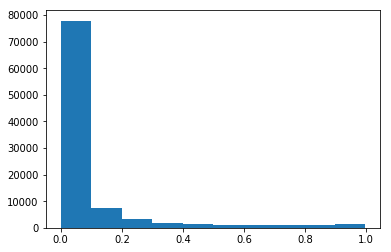

In [62]:
plt.hist(predictions)

(array([7254.,  665.,  307.,  176.,  133.,   85.,   83.,   86.,   97.,
         139.]),
 array([3.41057777e-04, 9.99988810e-02, 1.99656704e-01, 2.99314528e-01,
        3.98972351e-01, 4.98630174e-01, 5.98287997e-01, 6.97945820e-01,
        7.97603644e-01, 8.97261467e-01, 9.96919290e-01]),
 <a list of 10 Patch objects>)

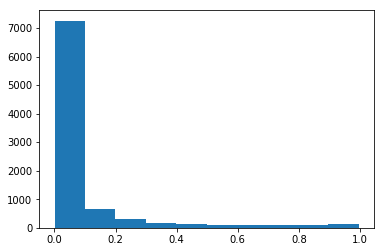

In [63]:
plt.hist(val_preds)

In [64]:
from sklearn.metrics import roc_auc_score

def power_mean(x, p=-5):
    return np.power(np.mean(np.power(x, p)),1/p)

def get_s_auc(y_true,y_pred,y_identity):
    mask = y_identity==1
    try:
        s_auc = roc_auc_score(y_true[mask],y_pred[mask])
    except:
        s_auc = 1
    return s_auc

def get_bpsn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==0) | (y_identity==0) & (y_true==1)
    try:
        bpsn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    except:
        bpsn_auc = 1
    return bpsn_auc

def get_bspn_auc(y_true,y_pred,y_identity):
    mask = (y_identity==1) & (y_true==1) | (y_identity==0) & (y_true==0)
    try:
        bspn_auc = roc_auc_score(y_true[mask],y_pred[mask])
    except:
        bspn_auc = 1
    return bspn_auc

def get_total_auc(y_true,y_pred,y_identities):

    N = y_identities.shape[1]
    
    saucs = np.array([get_s_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bpsns = np.array([get_bpsn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])
    bspns = np.array([get_bspn_auc(y_true,y_pred,y_identities[:,i]) for i in range(N)])

    M_s_auc = power_mean(saucs)
    M_bpsns_auc = power_mean(bpsns)
    M_bspns_auc = power_mean(bspns)
    rauc = roc_auc_score(y_true,y_pred)


    total_auc = M_s_auc + M_bpsns_auc + M_bspns_auc + rauc
    total_auc/= 4

    return total_auc

In [65]:
y_train[val_ind][:,0].shape, val_preds.shape,y_identities[val_ind].shape

((9025,), (9025,), (9025, 9))

In [66]:
get_total_auc(y_train[val_ind][:,0],val_preds,y_identities[val_ind])

0.8895331780129121

In [ ]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

In [ ]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/90527#latest-527799
import numpy as np
from sklearn.metrics import roc_auc_score


class JigsawEvaluator:

    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score

In [ ]:
# Your code here - remember to use markdown cells for comments as well!